In [1]:
# 그럼 데이터가 부족할땐 어떻게 하는가

In [2]:
# https://thebook.io/080228/part05/ch20/02/

In [3]:
# 치매/일반인 뇌 사진 분류 프로젝트를 하고 있는 우리에게도 이 자료가 중요한 이유는,
# 지금부터 이 방대한 양의 데이터셋에서 추출한 정보를 가져와서 
# 우리의 예측율을 극대화하는 ‘전이 학습’을 할 것이기 때문입니다.

In [4]:
# 뇌 사진만 다루는 치매 분류기를 만드는 데 
# 뇌 사진과 관련없는 수백만 장의 이미지넷 학습 정보가 큰 역할을 하는 이유는, 
# ‘형태’를 구분하는 기본적인 학습이 되어 있기 때문

# VGG16을 가져올 것

In [5]:
# 이제 앞서 우리가 만든 모델에 이미지넷 데이터셋에서, 
# 미리 학습된 모델인 VGGNet을 가지고 오는 예제를 실행해 보겠습니다.
# VGGNet은 옥스포드대학의 연구팀 VGG에 의해 개발된 모델로 
# 2014년 이미지넷 이미지 인식 대회에서 2위를 차지한 모델입니다. 
# 학습 구조에 따라 VGG16, VGG19 등의 이름이 주어졌는데 
# 우리는 VGG16을 사용하겠습니다.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.applications import VGG16

In [7]:
b_size = 5

train_datagen = ImageDataGenerator(rescale=1./255,
       horizontal_flip=True,      # 수평 대칭 이미지를 50% 확률로 만들어 추가
       width_shift_range=0.1,     # 전체 크기의 10% 범위에서 좌우로(random하게) 이동
       height_shift_range=0.1,    # 마찬가지로 위아래로(랜덤하게) 이동
                                  # rotation_range=5,  -> MRI사진을 회전시킨 이미지는 사용하지 않음
                                  # shear_range=0.7,  ->  MRI 를 한쪽으로 끄는 이미지도 안쓰고
                                  # zoom_range=[0.9, 2.2],   ->  MRI 사진 해상도는 정해져있어서 안씀
                                  # vertical_flip=True,
       fill_mode='nearest')


#train_generator = train_datagen.flow_from_directory(
train_generator = train_datagen.flow_from_directory(
    #'./train',                 # 학습셋이 있는 폴더 위치
    'data/치매MRI/train',
    target_size=(150, 150),
    #batch_size=5,
    batch_size=b_size,
    class_mode='binary')
# 폴더째로 타깃을 잡음(자동으로)

Found 160 images belonging to 2 classes.


In [8]:
# 테스트셋은 이미지 부풀리기 과정을 진행하지 않음
test_datagen = ImageDataGenerator(rescale=1./255)
 
#test_generator = test_datagen.flow_from_directory(
test_generator = test_datagen.flow_from_directory(
       #'./test',                   # 테스트셋이 있는 폴더 위치
    'data/치매MRI/test',
    target_size=(150, 150),
    batch_size=b_size,
    class_mode='binary')

Found 120 images belonging to 2 classes.


In [10]:
transfer_model = VGG16(weights = 'imagenet', include_top = False, # imagenet에서 학습한걸 가져온다는 뜻
                       input_shape = (150, 150, 3))
transfer_model.trainable = False
transfer_model.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

In [11]:
finetune_model = Sequential()
finetune_model.add(transfer_model)   # 하단에 껴놓고
finetune_model.add(Flatten())  # 맨 위에 우리가 만든걸 껴 놓음
finetune_model.add(Dense(64, activation='relu'))  # Flatten을 했으니까 Dense를 함
finetune_model.add(Dense(2, activation='softmax'))
finetune_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                524352    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 15,239,170
Trainable params: 524,482
Non-trainable params: 14,714,688
_________________________________________________________________


In [15]:
finetune_model.compile(loss='sparse_categorical_crossentropy', 
                       optimizer=optimizers.Adam(learning_rate=0.0002), 
                       metrics=['accuracy'])

steps_train = len(train_generator)
steps_test = len(test_generator)

hist= finetune_model.fit_generator(train_generator, steps_per_epoch=steps_train,
                                       epochs=20, validation_data=test_generator,
                                       validation_steps=steps_test)

Epoch 1/20
32/32 [==============================] - 2s 47ms/step - loss: 0.0835 - accuracy: 0.9688 - val_loss: 0.1296 - val_accuracy: 0.9583
Epoch 2/20
32/32 [==============================] - 1s 40ms/step - loss: 0.0753 - accuracy: 0.9625 - val_loss: 0.1657 - val_accuracy: 0.9333
Epoch 3/20
32/32 [==============================] - 1s 41ms/step - loss: 0.0876 - accuracy: 0.9688 - val_loss: 0.0923 - val_accuracy: 0.9667
Epoch 4/20
32/32 [==============================] - 1s 41ms/step - loss: 0.0532 - accuracy: 0.9937 - val_loss: 0.1537 - val_accuracy: 0.9417
Epoch 5/20
32/32 [==============================] - 1s 40ms/step - loss: 0.0548 - accuracy: 0.9750 - val_loss: 0.1049 - val_accuracy: 0.9583
Epoch 6/20
32/32 [==============================] - 1s 40ms/step - loss: 0.0821 - accuracy: 0.9625 - val_loss: 0.0919 - val_accuracy: 0.9583
Epoch 7/20
32/32 [==============================] - 1s 41ms/step - loss: 0.0670 - accuracy: 0.9875 - val_loss: 0.0790 - val_accuracy: 0.9667
Epoch 8/20
32

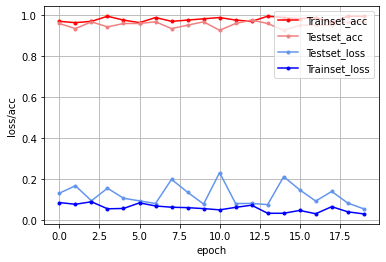

In [16]:
acc= hist.history['accuracy']
val_acc= hist.history['val_accuracy']
y_vloss = hist.history['val_loss']
y_loss = hist.history['loss']

x_len = np.arange(len(y_loss))  
plt.plot(x_len, acc, marker='.', c="red", label='Trainset_acc')
plt.plot(x_len, val_acc, marker='.', c="lightcoral", label='Testset_acc')
plt.plot(x_len, y_vloss, marker='.', c="cornflowerblue", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

plt.legend(loc='upper right') 
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss/acc')
plt.show()